<a href="https://colab.research.google.com/github/DrCet/Tutorials/blob/main/Attention_is_all_you_need_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[Attention Is All You Need](
https://doi.org/10.48550/arXiv.1706.03762)**

This notebook does not involve coding the Transformer from scratch, but rather provides an in-depth explanation of the Transformer based on the article "Attention is all you need" by Vaswani et al, and builds a Transformer model using the TensorFlow API.

##**1. Positional encoding**

While the order of data is automatically fed into RNNs, LSTMs, or GRUs, there is no inherent information about the order when training a Transformer network using multi-head attention. Therefore, you can specifically encode the positions of your inputs and pass them into the network, a process known as positional encoding.

In this implementation, the positional_encode function returns a tensor of shape **`(1, T, d_model)`**, where **`T`** is the maximum length of sequences and **`d_model`** is the embedding dimension.

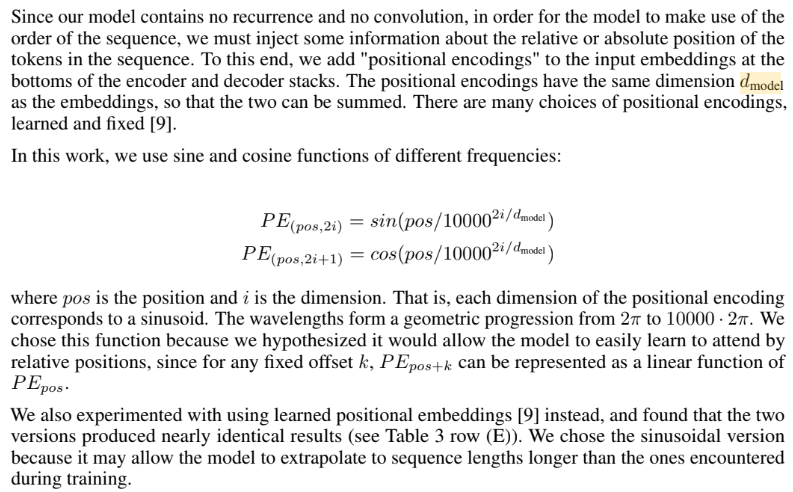

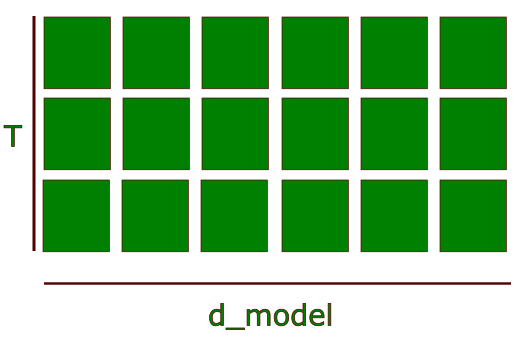

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_angles(pos, k, d):
  i = k // 2
  angles = pos / (10000**(2*i/d))
  return angles

pos = np.arange(4)[..., np.newaxis]
d = 8
k = np.arange(d)[np.newaxis, ...]
print(get_angles(pos, k, d))

[[0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e+00 1.e+00 1.e-01 1.e-01 1.e-02 1.e-02 1.e-03 1.e-03]
 [2.e+00 2.e+00 2.e-01 2.e-01 2.e-02 2.e-02 2.e-03 2.e-03]
 [3.e+00 3.e+00 3.e-01 3.e-01 3.e-02 3.e-02 3.e-03 3.e-03]]


(1, 586, 1028)


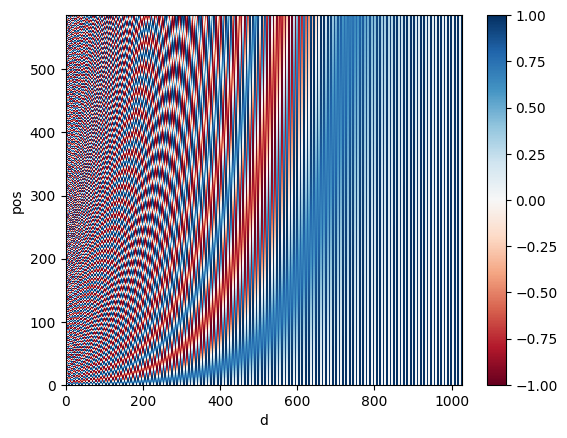

In [3]:
def positional_encode(pos:int, d:int):
  angles = get_angles(np.arange(pos)[...,np.newaxis],
                      np.arange(d)[np.newaxis,...],
                      d)
  angles[:,0::2] = np.sin(angles[:,0::2])
  angles[:,1::2] = np.cos(angles[:,1::2])

  return angles[np.newaxis, ...]
pos_encoding = positional_encode(586, 1028)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0,1028))
plt.ylabel('pos')
plt.colorbar()
plt.show()

## **2. Masking**

In [4]:
import tensorflow as tf
import numpy as np

### **2.1. Padding mask**

The padding mask is used to set all zeros in the sequence to a value close to negative infinity. This ensures that the zeros do not affect the softmax distribution. We will create the padding mask using the **`create_padding_mask`** function, where a tensor value of 0 will correspond to a mask value of 0.

The attention mask is not calculated using this function or the attention_weights tensor. Instead, we will use this function to calculate the mask for the **`query`** and **`value`**, and then pass them into the **`MultiHeadAttention`** layer.

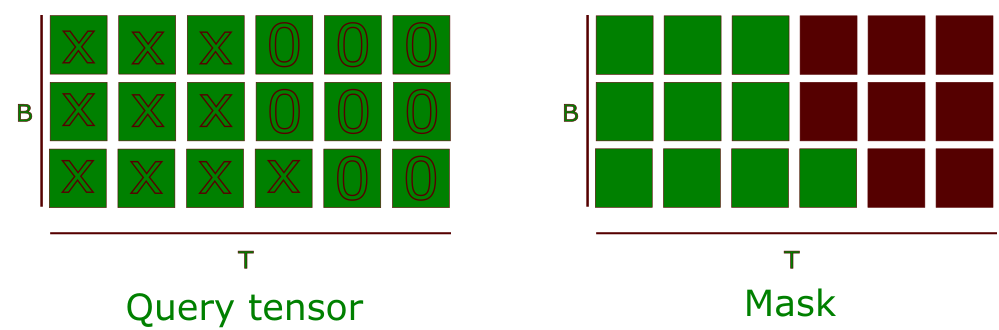

In [5]:
def create_padding_mask(tensor):
  mask = 1 - tf.cast(tf.math.equal(tensor, 0), tf.float32)
  return mask
x = np.array([[7., 5., 8., 0., 0.,],
             [7., 5., 8., 1., 0.,]])
print(create_padding_mask(x))

print(f'Softmax before masking:\n{tf.keras.activations.softmax(x)}\n')

print(f'Softmax after padding:\n{tf.keras.activations.softmax(x + (1-create_padding_mask(x))*-1e9)}')

tf.Tensor(
[[1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]], shape=(2, 5), dtype=float32)
Softmax before masking:
[[2.59373709e-01 3.51024144e-02 7.05050840e-01 2.36518208e-04
  2.36518208e-04]
 [2.59268341e-01 3.50881544e-02 7.04764420e-01 6.42661965e-04
  2.36422125e-04]]

Softmax after padding:
[[2.5949645e-01 3.5119027e-02 7.0538449e-01 0.0000000e+00 0.0000000e+00]
 [2.5932965e-01 3.5096452e-02 7.0493108e-01 6.4281392e-04 0.0000000e+00]]


### **2.2. Look-ahead mask**

The look-ahead mask is crucial in autoregressive models. For example, if we have a sequence **`[1, 2, 3]`**, during training, the model should only predict the next value based on what it has seen so far. If the input is **`[1]`**, we want the model to predict **`2`**. We mask the remaining values like **`[1, -1e9, -1e9]`**, ensuring the model only sees the first value when predicting the next and can't look ahead.

This type of mask calculation is supported by the **`MultiHeadAttention`** layer, so the function we define here is just used to illustrate the intuition behind this look-ahead mask, also known as the causal mask.

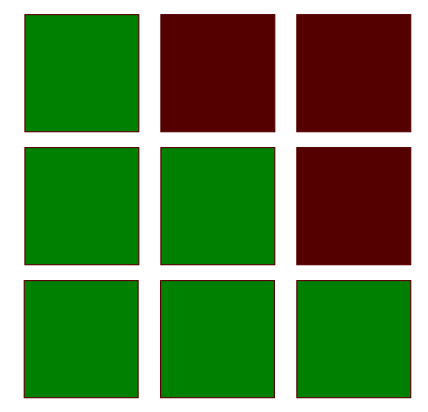

In [6]:
def create_lookahead_mask(sequence_length):
  return tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)

x= tf.random.uniform((1, 5))
print(create_lookahead_mask(x.shape[1]))

tf.Tensor(
[[[1. 0. 0. 0. 0.]
  [1. 1. 0. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 1. 0.]
  [1. 1. 1. 1. 1.]]], shape=(1, 5, 5), dtype=float32)


##**3. Self-Attention**

**Scaled dot-product**

The scaled dot-product is used to calculate a representation of words in the query that are relevant to the values. The softmax term calculates the attention weights, which is a tensor that represents the dependencies between the query and key.

The function will take **`Q`**, **`K`**, **`V`** and **`mask`** as inputs.

In self-attention, **`Q`**, **`K`**, **`V`** are derived from the same source so they have the same maximum length.

    Q -- query shape = `(batch_size, T, d_k)`

    K -- key shape = `(batch_size, S, d_k)`
    
    v -- value shape = (batch_size, S, d_v)



The tensor after calling softmax is the attention_weights with shape **`(batch_size, T, S)`**
The the last output will have the shape  **`(batch_size, T, d_v)`**

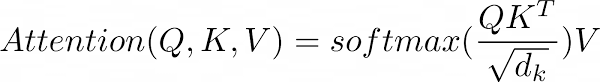

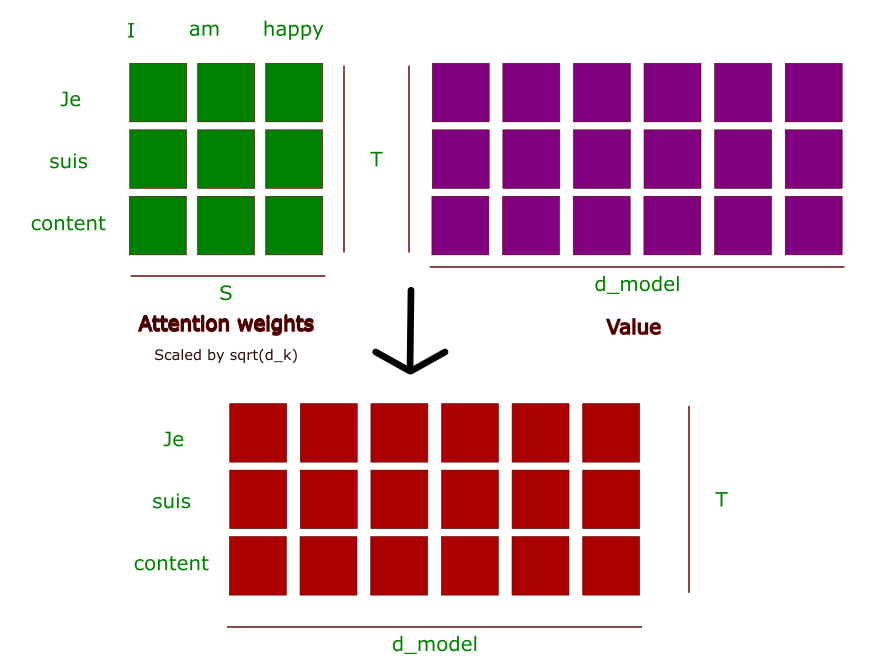

In [7]:
def scaled_dot_product_attention(q,v,k,mask):
  qk = tf.matmul(q, k.T)
  dk = k.shape[-1]
  scaled_qk = qk / np.sqrt(dk)
  scaled_qk = tf.cast(scaled_qk, tf.float32)
  if mask is not None:
    scaled_qk = scaled_qk + (1-mask)*-1e9
  attention_weights = tf.keras.activations.softmax(scaled_qk)
  output = tf.matmul(attention_weights, v)
  return output, attention_weights

q = np.array([[5.,4.,3., 0., 0.],
              [2., 8., 1., 9., 4.]]).T
k = np.array([[1., 8., 5. ,4.,3., 5., 0.],
                 [7, 3, 2., 8., 1., 0., 0.]]).T
v = k
mask = create_padding_mask(np.dot(q,k.T))
print(f'Mask:\n{mask}')
output, attention_weights = scaled_dot_product_attention(q,v,k, mask)
print(f'Output:\n{output}')
print(f'Attention weights:\n{attention_weights}')




Mask:
[[1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0.]]
Output:
[[7.996587  3.004236 ]
 [3.999998  7.9999995]
 [7.9686756 3.0336947]
 [3.994841  7.99828  ]
 [3.832581  7.944189 ]]
Attention weights:
[[5.1065596e-09 9.9914503e-01 6.0124867e-06 8.4859959e-04 1.2414906e-09
  3.5537280e-07 0.0000000e+00]
 [7.2135367e-07 4.2636177e-08 3.0755783e-14 9.9999928e-01 3.7535768e-19
  3.7535768e-19 0.0000000e+00]
 [5.9689787e-06 9.9191296e-01 8.4245723e-04 7.0279026e-03 5.9689787e-06
  2.0481551e-04 0.0000000e+00]
 [1.7195629e-03 1.5138608e-14 2.6076677e-17 9.9828041e-01 4.4917901e-20
  0.0000000e+00 0.0000000e+00]
 [5.5807218e-02 6.8109688e-07 4.0256769e-08 9.4419205e-01 2.3794036e-09
  0.0000000e+00 0.0000000e+00]]


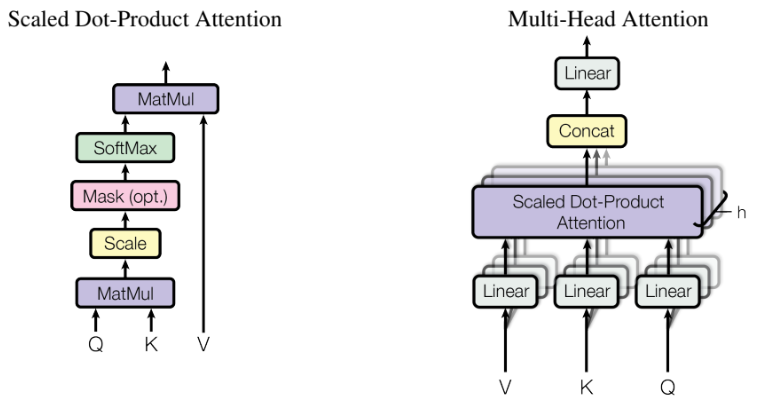

##**4. Encoder**


###**4.1. Encoder Layer**

We will use **[MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)** layer provided by keras to implement this customlayer.

See source code of **`MultiHeadAttention`** **[here](https://github.com/keras-team/keras/blob/v3.3.3/keras/src/layers/attention/multi_head_attention.py#L19-L636)**


In self-attention, **`Q`**, **`K`**, **`V`** should be the same.




**Important notes**

The **`call`** method of the **`MultiHeadAttention`** class requires **`Q`** and **`V`** as inputs, and accepts 4 optional masks as tensors. Additionally, **`use_causal_mask`** should be set to **`True`** in the case of the decoder. Both attention_mask and causal_mask are calculated using **`query_mask`**, **`key_mask`** by the functions **`_compute_causal_mask`** and **`_compute_attention_mask`**, respectively.


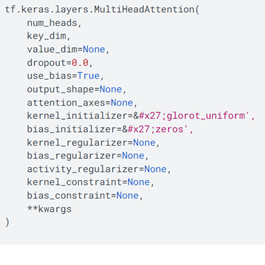

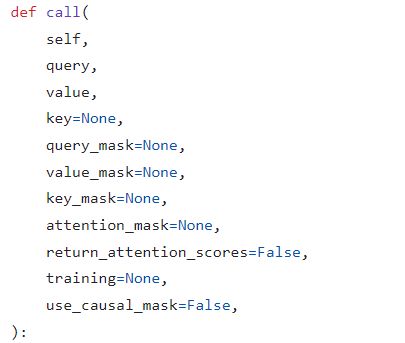

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Embedding, Dropout
tf.random.set_seed(10)

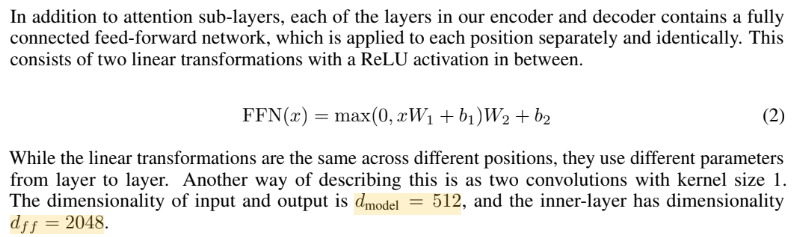

In [9]:
def FullyConnected(fully_connected_dim, embedding_dim):
  return tf.keras.models.Sequential([
      Dense(fully_connected_dim, activation='relu'),
      Dense(embedding_dim) #This return output with shape (batch_size, input_seq_len, embedding_dim) >> concatenate
  ])

The `EncoderLayer` will return a tensor with shape `(B, T, d_model)`.
Each head returns a tensor with shape `(B, T, d_model/num_heads)` so after concatenating, we'll get the desired output shape. The `fully_connected_dim = 2048` in the original paper "Attention is all you need"

`d_model`: embedding_dim

`B`: Batch size

`T`: Input sequence length

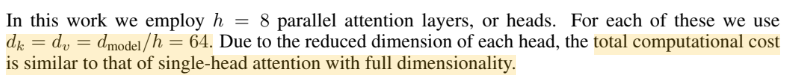

We call **`self_mha_output = self.mha(x, x, x, mask, mask, mask)`** because in self-attention, **`Q`**, **`K`** and **`V`** are literally the same as well as their masks.

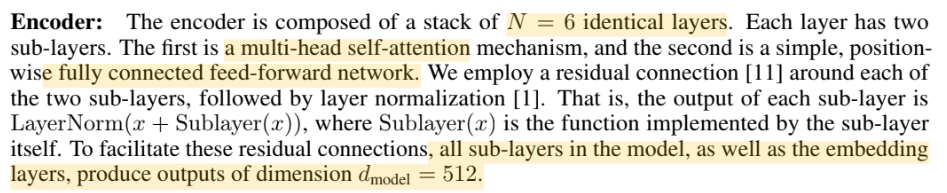

In [10]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, embedding_dim, fully_connected_dim, num_heads, dropout_rate=0.1, layernorm_eps=1e-6):
    super().__init__()
    self.mha = MultiHeadAttention(num_heads=num_heads,
                                  key_dim=embedding_dim,
                                  dropout=dropout_rate)

    self.ffn = FullyConnected(fully_connected_dim=fully_connected_dim, embedding_dim=embedding_dim)
    self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
    self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

  def call(self, Q, Q_mask, training):
    self_mha_output = self.mha(Q, Q, Q, Q_mask, Q_mask, Q_mask)   #output shape (batch_size, input_seq_len, embdding_dim)
    skip_x_attention = self.layernorm1(Q+self_mha_output)
    ffn_output = self.ffn(skip_x_attention)
    encoder_layer_out = self.layernorm2(skip_x_attention+ffn_output)
    return encoder_layer_out


In the Encoder, self-attention is used so **`query`**, **`key`**, **`value`**: shape **`(B, T)`**, the masks of these tensors also have the same shape. The tensors after embedding will have shape **`(B, T, d_model)`**

Positional encoding tensor will have shape **`(1, T, d_model)`**. The shape in the **`axis=0`** is 1 to make sure it is broadcastable for addition to any value of **`B`**.

The positional encoding tensor is not supported by the **`MultiHeadAttention`** class, so we need to define a separate function for that.

###**4.2. Encoder**

In [11]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, embedding_dim, fully_connected_dim, num_heads, input_vocab_size, maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.num_layers = num_layers
    self.embedding = Embedding(input_dim=input_vocab_size, output_dim=self.embedding_dim)
    self.pos_encoding = positional_encode(maximum_position_encoding, self.embedding_dim)

    self.enc_layers = [EncoderLayer(self.embedding_dim,
                                    fully_connected_dim,
                                    num_heads,
                                    dropout_rate=dropout_rate,
                                    layernorm_eps=layernorm_eps)
    for _ in range(self.num_layers)]
    self.dropout = Dropout(dropout_rate)

  def call(self, Q, Q_mask, training):
    seq_len = tf.shape(Q)[1]
    x = self.embedding(Q)
    x *= np.sqrt(tf.cast(x.shape[-1], tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, Q_mask, training=training)

    return x #(batch_size, input_seq_len, embedding_dim) same shape as the embedded input

In [12]:
Q = np.array([[ 9.,  3., 0., 0.],
              [ 7.,  8., 9., 0.],
              [ 7.,  0., 0., 0.]])
Q_mask = create_padding_mask(Q)
encoder = Encoder(num_layers=6, embedding_dim=512, fully_connected_dim=2048, num_heads=8, input_vocab_size=16, maximum_position_encoding=4)
encoding_output = encoder(Q, Q_mask, training=True)
print(encoding_output)

tf.Tensor(
[[[-3.86574316e+00  3.81387055e-01 -5.78760326e-01 ...  4.45997924e-01
   -7.59238720e-01 -1.58789265e-03]
  [-2.10089970e+00 -3.50274622e-01 -9.39140141e-01 ...  4.60768700e-01
   -9.37212184e-02  1.75795460e+00]
  [-1.39409781e+00 -7.73186922e-01 -1.14021897e-01 ... -1.10256696e+00
   -3.08639884e+00 -9.81319696e-02]
  [-1.00323975e+00 -9.03613925e-01  1.20243775e-02 ... -9.66163695e-01
   -3.41624951e+00  5.11550903e-01]]

 [[-2.32291770e+00  1.32699072e+00 -8.63981128e-01 ...  1.40509486e-01
   -1.41953290e+00  4.46103901e-01]
  [-1.53847480e+00 -5.15153229e-01  3.83299768e-01 ...  9.62461948e-01
   -6.43289864e-01  1.12115598e+00]
  [-2.79369712e+00 -8.15319359e-01  1.75304696e-01 ... -4.16463286e-01
   -2.35700250e+00  7.51874804e-01]
  [-6.24821067e-01 -1.59555888e+00  2.98735321e-01 ... -5.97356617e-01
   -3.12857985e+00  1.28882587e-01]]

 [[-2.67644334e+00  7.88737237e-01 -4.11662161e-01 ...  6.61570355e-02
   -1.08237410e+00  3.85288417e-01]
  [-1.55437303e+00 -2.

Here are the function **`_compute_causal_mask`** and **`_compute_attention_mask`** from the **`MultiHeadAttention`** [source](https://github.com/keras-team/keras/blob/v3.3.3/keras/src/layers/attention/multi_head_attention.py#L550) code.

In [13]:
from keras.src import ops

def _compute_causal_mask(query, value=None):
        """Computes a causal mask (e.g., for masked self-attention layers).

        For example, if query and value both contain sequences of length 4,
        this function returns a boolean tensor equal to:

        ```
        [[[True,  False, False, False],
          [True,  True,  False, False],
          [True,  True,  True,  False],
          [True,  True,  True,  True]]]
        ```

        Args:
            query: query tensor of shape `(B, T, ...)`.
            value: value tensor of shape `(B, S, ...)` (optional, defaults to
                query).

        Returns:
            mask: a boolean tensor of shape `(1, T, S)` containing a lower
                triangular matrix of shape `(T, S)`.
        """
        q_seq_length = ops.shape(query)[1]
        v_seq_length = q_seq_length if value is None else ops.shape(value)[1]
        ones_mask = ops.ones((1, q_seq_length, v_seq_length), dtype="int32")
        row_index = ops.cumsum(ones_mask, axis=-2)
        col_index = ops.cumsum(ones_mask, axis=-1)
        return ops.greater_equal(row_index, col_index)

def _compute_attention_mask(
        query,
        value,
        query_mask=None,
        value_mask=None,
        key_mask=None,
        attention_mask=None,
        use_causal_mask=False,
    ):
        """Computes the attention mask, using the Keras masks of the inputs.

        * The `query`'s mask is reshaped from [B, T] to [B, T, 1].
        * The `value`'s mask is reshaped from [B, S] to [B, 1, S].
        * The `key`'s mask is reshaped from [B, S] to [B, 1, S]. The `key`'s
          mask is ignored if `key` is `None` or if `key is value`.
        * If `use_causal_mask=True`, then the causal mask is computed. Its shape
          is [1, T, S].

        All defined masks are merged using a logical AND operation (`&`).

        In general, if the `query` and `value` are masked, then there is no need
        to define the `attention_mask`.

        Args:
            query: Projected query tensor of shape `(B, T, N, key_dim)`.
            key: Projected key tensor of shape `(B, T, N, key_dim)`.
            value: Projected value tensor of shape `(B, T, N, value_dim)`.
            attention_mask: a boolean mask of shape `(B, T, S)`, that prevents
                attention to certain positions.
            use_causal_mask: A boolean to indicate whether to apply a causal
                mask to prevent tokens from attending to future tokens (e.g.,
                used in a decoder Transformer).

        Returns:
            attention_mask: a boolean mask of shape `(B, T, S)`, that prevents
                attention to certain positions, based on the Keras masks of the
                `query`, `key`, `value`, and `attention_mask` tensors, and the
                causal mask if `use_causal_mask=True`.
        """
        auto_mask = None
        if query_mask is not None:
            query_mask = ops.cast(query_mask, "bool")  # defensive casting
            # B = batch size, T = max query length
            auto_mask = ops.expand_dims(query_mask, -1)  # shape is [B, T, 1]
        if value_mask is not None:
            value_mask = ops.cast(value_mask, "bool")  # defensive casting
            # B = batch size, S == max value length
            mask = ops.expand_dims(value_mask, -2)  # shape is [B, 1, S]
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if key_mask is not None:
            key_mask = ops.cast(key_mask, "bool")  # defensive casting
            # B == batch size, S == max key length == max value length
            mask = ops.expand_dims(key_mask, -2)  # shape is [B, 1, S]
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if use_causal_mask:
            # the shape of the causal mask is [1, T, S]
            mask = _compute_causal_mask(query, value)
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if auto_mask is not None:
            # merge attention_mask & automatic mask, to shape [B, T, S]
            attention_mask = (
                auto_mask
                if attention_mask is None
                else ops.cast(attention_mask, bool) & auto_mask
            )
        return attention_mask

V = np.array([[ 9.,  3., 6., 0., 0.],
              [ 7.,  8., 9., 7., 0.],
              [ 7.,  3., 0., 0., 0.]])

print(_compute_causal_mask(Q, V))


tf.Tensor(
[[[ True False False False False]
  [ True  True False False False]
  [ True  True  True False False]
  [ True  True  True  True False]]], shape=(1, 4, 5), dtype=bool)


##**5. Decoder**

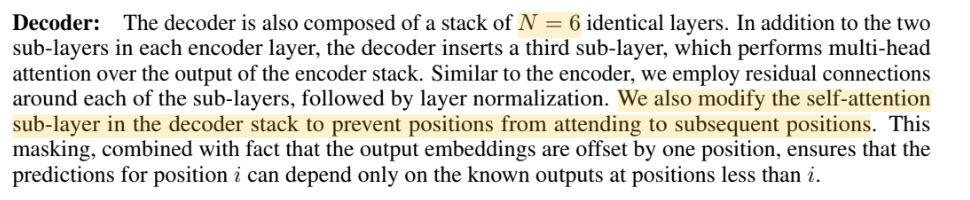

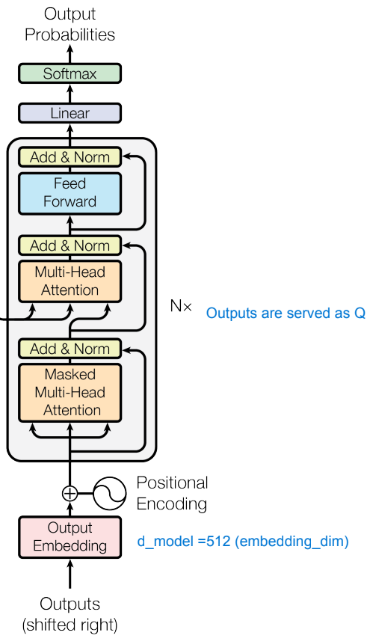

In [14]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, embedding_dim, fully_connected_dim, num_heads, dropout_rate=0.1, layernorm_eps=1e-6):
    super().__init__()
    self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                   key_dim=embedding_dim,
                                   dropout=dropout_rate)
    self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                   key_dim=embedding_dim,
                                   dropout=dropout_rate)
    self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
    self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
    self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

    self.ffn = FullyConnected(fully_connected_dim=fully_connected_dim, embedding_dim=embedding_dim)
    self.dropout_ffn = Dropout(dropout_rate)

  def call(self, x, encoding_output, Q_mask, V_mask, training):   # Q_mask and V_mask are padding mask
    self_mha1_out = self.mha1(x, x, x, Q_mask, Q_mask, Q_mask, use_causal_mask=True)
    layernorm1_out = self.layernorm1(x+self_mha1_out)

    self_mha2_out = self.mha2(self_mha1_out, encoding_output, encoding_output, Q_mask, V_mask, V_mask)

    layernorm2_out = self.layernorm2(layernorm1_out + self_mha2_out)
    ffn_out = self.ffn(layernorm2_out)
    ffn_out = self.dropout_ffn(ffn_out, training=training)
    final_out = self.layernorm3(layernorm2_out + ffn_out)

    return final_out

In [15]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, embedding_dim, fully_connected_dim, num_heads, input_vocab_size, maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
    super().__init__()
    self.num_layers = num_layers
    self.embedding = Embedding(input_vocab_size, embedding_dim)
    self.pos_encoding = positional_encode(maximum_position_encoding, embedding_dim)
    self.dec_layers = [DecoderLayer(embedding_dim=embedding_dim,
                                    fully_connected_dim=fully_connected_dim,
                                    num_heads=num_heads,
                                    dropout_rate=dropout_rate,
                                    layernorm_eps=1e-6)
                      for _ in range(num_layers)]

  def call(self, x, encoding_output, Q_mask, V_mask, training):
    x = self.embedding(x)
    x *= np.sqrt(tf.cast(x.shape[-1], tf.float32))
    seq_len = tf.shape(x)[1]
    x += self.pos_encoding[:, :seq_len, :]

    for i in range(self.num_layers):
      x = self.dec_layers[i](x, encoding_output, Q_mask, V_mask, training=training)

    return x



In [16]:
decoder = Decoder(num_layers=6, embedding_dim=512, fully_connected_dim=2048, num_heads=8, input_vocab_size=16, maximum_position_encoding=6)
Q_input = np.array([[ 9.,  3., 0., 0.],
              [ 7.,  8., 9., 0.],
              [ 7.,  0., 0., 0.]])

Q_input_mask = create_padding_mask(Q_input)

encoder = Encoder(num_layers=6, embedding_dim=512, fully_connected_dim=2048, num_heads=8, input_vocab_size=16, maximum_position_encoding=4)
encoding_output = encoder(Q_input, Q_input_mask, training=True)


V_mask = Q_input_mask
Q_label = np.array([[ 9.,  3., 9.,  3., 0., 0.],
                    [ 9.,  3., 7.,  8., 9., 0.],
                    [ 9.,  3., 7.,  0., 0., 0.]])
Q_label_mask = create_padding_mask(Q_label)
decoding_output = decoder(Q_label, encoding_output, Q_label_mask, V_mask, training=True)
print(decoding_output)

tf.Tensor(
[[[ 1.0923918   0.27710474 -1.6516114  ... -0.96864307 -0.17663056
    0.1477046 ]
  [ 0.69486016 -0.72394085 -0.23651184 ...  0.9742537   0.6470317
    0.07840785]
  [ 0.5120573  -1.090271   -0.46859267 ... -0.69807714  0.92362404
    0.8156417 ]
  [ 0.996859   -1.0917292   0.28525862 ...  0.5631972  -0.7666736
    0.2668427 ]
  [-0.05569139 -0.7656393   0.10435311 ...  0.32390982 -0.3828166
    0.89695317]
  [-0.06775874 -0.31477973  0.64261514 ...  0.01561979 -0.4860489
   -0.02482224]]

 [[ 1.4839509  -0.97708094 -1.0983576  ... -0.7870101  -0.4517222
    0.07044366]
  [ 1.110817   -1.2636964   0.29477942 ...  0.7956562  -0.43985572
   -0.14859974]
  [-0.5356385  -0.16796595  0.08681577 ...  0.01364157 -1.7668628
   -0.7239223 ]
  [ 0.51292014 -1.1106535  -0.44474733 ...  0.5605326   0.94606453
    0.21241719]
  [-0.18135154 -0.78435403 -1.1402626  ... -0.03824776  0.87094235
    0.5140202 ]
  [ 0.30362648  0.32085478  0.03093023 ...  0.5293844  -0.6643382
    0.47789785

##**6.Model**

In [17]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, embedding_dim, fully_connected_dim, num_heads, input_vocab_size, target_vocab_size, input_maximum_position_encoding, output_maximum_position_encoding,dropout_rate=0.1, layernorm_eps=1e-6):  #new parameter: target_vocab_size
    super().__init__()
    self.encoder = Encoder(num_layers, embedding_dim, fully_connected_dim, num_heads, input_vocab_size, input_maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6)
    self.decoder = Decoder(num_layers, embedding_dim, fully_connected_dim, num_heads, target_vocab_size, output_maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6)
    self.softmax = Dense(target_vocab_size, activation='softmax')

  def call(self, input_sequences, output_sequences, input_mask, output_mask, training):
    encoding_output = self.encoder(input_sequences, input_mask, training=training)
    decoding_output = self.decoder(output_sequences, encoding_output, output_mask, input_mask, training=training)
    final_output = self.softmax(decoding_output)
    return final_output


In [18]:
transformer = Transformer(num_layers=6,
                          embedding_dim=512,
                          fully_connected_dim=2048,
                          num_heads=8,
                          input_vocab_size=25000,
                          target_vocab_size=25000,
                          input_maximum_position_encoding=512,
                          output_maximum_position_encoding=512,
                          dropout_rate=0.1,
                          layernorm_eps=1e-6)

In [19]:
input_sequences = np.random.randint(0,25000,(8,512))
output_sequences = np.random.randint(0,25000,(8,512))

input_mask = create_padding_mask(input_sequences)
output_mask = create_padding_mask(output_sequences)
print(transformer(input_sequences, output_sequences, input_mask, output_mask, training=True))

tf.Tensor(
[[[4.5842888e-05 3.5831188e-05 4.1656149e-05 ... 3.6190308e-05
   4.0177049e-05 4.7893078e-05]
  [4.3717206e-05 2.0863794e-05 4.5484230e-05 ... 3.8740251e-05
   3.6147205e-05 4.3495995e-05]
  [3.0727024e-05 3.1234922e-05 3.2222430e-05 ... 4.3907832e-05
   4.0013085e-05 4.4298242e-05]
  ...
  [4.0993669e-05 3.4949309e-05 4.6906935e-05 ... 4.2242584e-05
   3.3462791e-05 4.8664755e-05]
  [3.8455317e-05 2.4298204e-05 4.7675483e-05 ... 4.9816252e-05
   4.0082436e-05 4.6878584e-05]
  [4.1452127e-05 2.4868588e-05 4.1002182e-05 ... 5.7582234e-05
   4.0363368e-05 4.8412367e-05]]

 [[3.9298986e-05 2.6874995e-05 4.3448166e-05 ... 5.0960982e-05
   3.4495533e-05 4.5829318e-05]
  [4.1748099e-05 3.1877167e-05 4.1107174e-05 ... 3.5448706e-05
   3.9838575e-05 5.4995471e-05]
  [4.2445339e-05 3.5103145e-05 3.4101457e-05 ... 4.1446099e-05
   3.7697482e-05 4.0801679e-05]
  ...
  [3.9128929e-05 2.6385183e-05 5.2482665e-05 ... 4.1147174e-05
   3.5482353e-05 5.2203453e-05]
  [3.5977682e-05 3.404247

The final output has shape **`(B, T, output_vocab_size)`**, this shape is useful for the translation task.




In [20]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_2 (Encoder)                  │ ?                           │      75,819,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (Decoder)                  │ ?                           │     126,233,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (8, 512, 25000)             │      12,825,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,877,608 (819.69 MB)

 Trainable params: 214,877,608 (819.69 MB)

 Non-trainable params: 0 (0.00 B)